## EDA for the popular battle royale game PUBG

In [11]:
%%html
<img src="data/battle_royale.jpg", width=800, height=300>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 45)

In [2]:
train = pd.read_csv('data/train_V2.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


- <b>groupId</b> - Integer ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- <b>matchId</b> - Integer ID to identify match. There are no matches that are in both the training and testing set.
- assists - Number of enemy players this player damaged that were killed by teammates.
- boosts - Number of boost items used.
- damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
- DBNOs - Number of enemy players knocked.
- headshotKills - Number of enemy players killed with headshots.
- heals - Number of healing items used.
- killPlace - Ranking in match of number of enemy players killed.
- killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.)
- kills - Number of enemy players killed.
- killStreaks - Max number of enemy players killed in a short amount of time.
- longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a - player and driving away may lead to a large longestKill stat.
- maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- numGroups - Number of groups we have data for in the match.
- revives - Number of times this player revived teammates.
- rideDistance - Total distance traveled in vehicles measured in meters.
- roadKills - Number of kills while in a vehicle.
- swimDistance - Total distance traveled by swimming measured in meters.
- teamKills - Number of times this player killed a teammate.
- vehicleDestroys - Number of vehicles destroyed.
- walkDistance - Total distance traveled on foot measured in meters.
- weaponsAcquired - Number of weapons picked up.
- winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.)
- winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [3]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


# Exploratory Data Analysis

### The killers

In [4]:
print("The average person kills {:.4f} players, 99% of people have {} kills or less, most kills recorded is {}".format(train['kills'].mean(), train['kills'].quantile(0.99), train['kills'].max()))

The average person kills 0.9248 players, 99% of people have 7.0 kills or less, most kills recorded is 72


In [5]:
data = train.copy()

In [6]:
data[data['kills'] > data['kills'].quantile(0.99)] = "8+"

Text(0.5, 1.0, 'Kill Count')

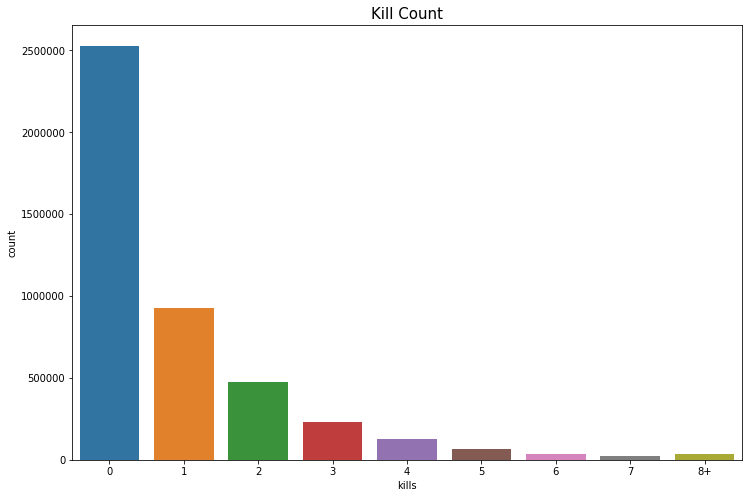

In [7]:
plt.figure(figsize=(12,8))
sb.countplot(data['kills'].astype('str').sort_values())
plt.title('Kill Count', fontsize=15)

Most players have zero kills, let's see the damage they do at least

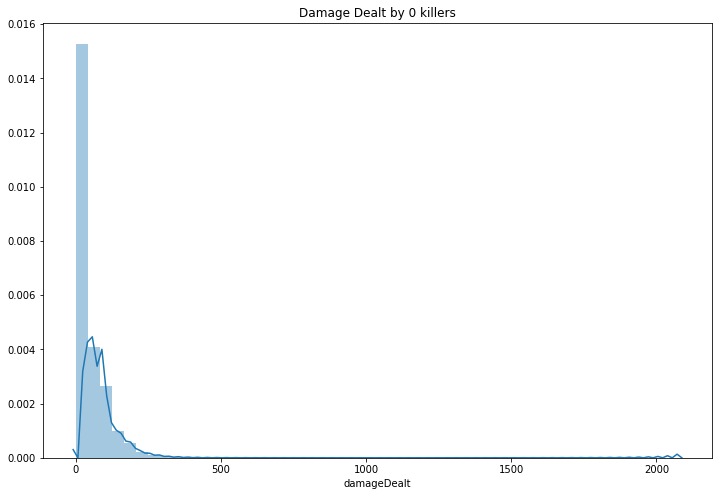

In [8]:
data = train.copy()
data = data[data['kills']==0]
plt.figure(figsize=(12, 8))
sb.distplot(data['damageDealt'])
plt.title('Damage Dealt by 0 killers');

Most players with zero kills deal no damage. Let's see the few that do

In [9]:
print('{} players ({:.4f}%) won without getting a single kill!'.format(data[data['winPlacePerc'] == 1].shape[0],
                                                                  data[data['winPlacePerc'] == 1].shape[0] / train.shape[0]))
data1 = train[train['damageDealt'] == 0].copy()
print('{} players ({:.4f}%) won without dealing any damage'.format(data1[data1['winPlacePerc'] == 1].shape[0], 
                                                              data1[data1['winPlacePerc'] == 1].shape[0] / train.shape[0]))

16666 players (0.0037%) won without getting a single kill!
4770 players (0.0011%) won without dealing any damage


Plot win placement percentage vs kills

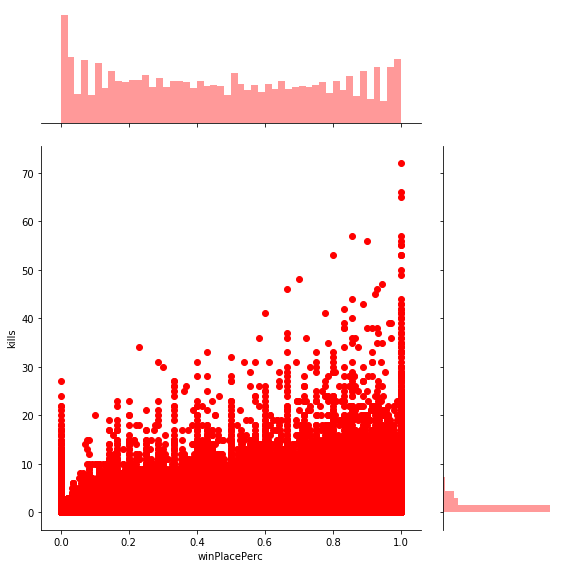

In [10]:
sb.jointplot(x='winPlacePerc', y='kills', data=train, color='r', height=8, ratio=3);

Kills is correlated with winning. Let's break it down by groups with 10+ kills

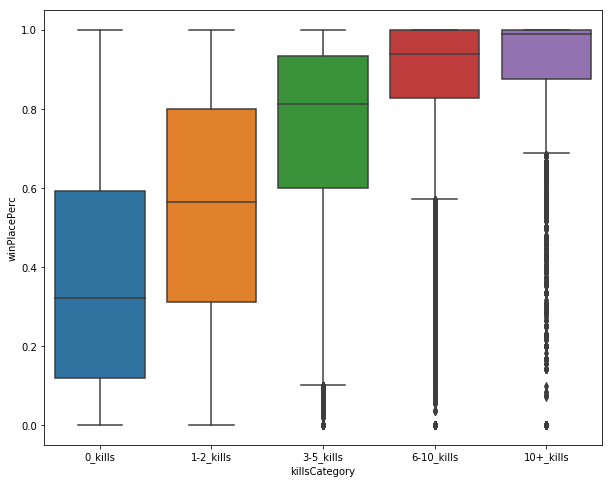

In [11]:
kills = train.copy()

kills['killsCategory'] = pd.cut(kills['kills'], [-1, 0, 2, 5, 10, 60], 
                                labels=['0_kills', '1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])
plt.figure(figsize=(10, 8))
sb.boxplot(x='killsCategory', y='winPlacePerc',data=kills)